## Part 1: Preprocessing the Data

In [ ]:
!pip install -q transformers datasets rouge-score

In [ ]:
#install spacy large language model
!python -m spacy download en_core_web_sm

In [3]:
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
  
import tensorflow_hub as hub
from tensorflow import keras 
import tensorflow as tf
from IPython.display import Image 
import matplotlib.pyplot as plt


nlp = spacy.load('en_core_web_sm')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cnn_ds = pd.read_csv('/content/drive/MyDrive/PlakshaNLP/Project/test.csv')

In [ ]:
cnn_ds

In [31]:
x='there was a man. there was a dear. the maker is dead'

In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
cnn_df = pd.DataFrame(cnn_ds)
#cnn_df.highlights = cnn_df.highlights.apply(lambda x: x.decode('utf-8')) 
cnn_df["summary"] = cnn_df.highlights.apply(lambda x: "".join(x.split("\n")) ) 
#cnn_df.article = cnn_df.article.apply(lambda x: x.decode('utf-8')) 
cnn_df["art_sents"] = cnn_df.article.apply(lambda x: len([x for x in sent_tokenize(x)])) 
#x = cnn_df.article.apply(lambda x: len([x for x in sent_tokenize(x)]))
cnn_df

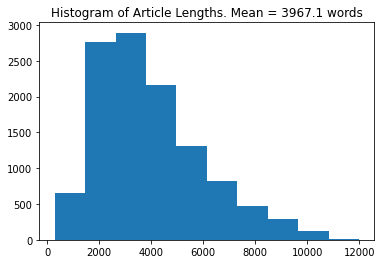

In [10]:
art_lengths = [ len(x) for x in cnn_df.article] 
plt.hist(art_lengths);
plt.title("Histogram of Article Lengths. Mean = " + str(round(sum(art_lengths)/ len(art_lengths),1)) + " words" );

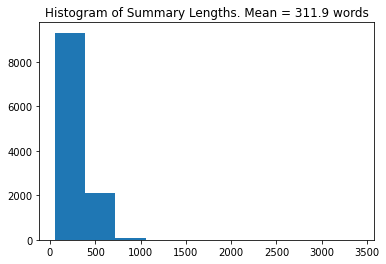

In [11]:
sum_lengths = [ len(x) for x in cnn_df.highlights] 
plt.hist(sum_lengths);
plt.title("Histogram of Summary Lengths. Mean = " + str(round(sum(sum_lengths)/ len(sum_lengths),1)) + " words" );

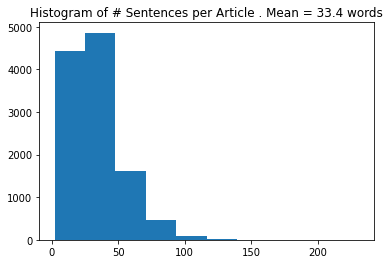

In [12]:
# art_lengths = [ len(x) for x in cnn_df.article] 
plt.hist(cnn_df.art_sents);
plt.title("Histogram of # Sentences per Article . Mean = " + str(round(sum(cnn_df.art_sents)/ len(cnn_df.art_sents),1)) + " words" );

### Exporting the Data for future reuse
This will ensure that we dont have to download the data everytime we run this code.

In [14]:
import os

In [15]:
train_df = pd.read_csv('/content/drive/MyDrive/PlakshaNLP/Project/test.csv')
test_df = pd.read_csv('/content/drive/MyDrive/PlakshaNLP/Project/validation.csv')

In [ ]:
test_df

In [19]:
train_df = train_df.drop(['id'], axis = 1)
test_df = test_df.drop(['id'], axis = 1)
test_df.shape, train_df.shape

((13368, 2), (11490, 2))

In [ ]:
#os.makedirs("data/", exist_ok=True) 
#os.makedirs("data/test", exist_ok=True) 
#os.makedirs("data/train", exist_ok=True) 

#test_df.to_json("data/test/test.json")
#train_df.to_json("data/train/train.json")

### Preprocessing using Spacy library

In [21]:
def get_dicts(df, folder="test"):   
  sents_dict = {}
  doc_dict = { i: {"article": df.article[i], "highlight": df.highlights[i]} for i in df.index }
  raw_docs = [ doc_dict[k]["article"] for k in doc_dict.keys()]

  doc_sents = {}
  sents_list = []
  raw_sents = [] 
  i = 0
  min_sent_length = 14
  for k in tqdm(doc_dict.keys()):
    article = doc_dict[k]["article"]  
    highlight = doc_dict[k]["highlight"] 
    sents = sent_tokenize(article)
    doc_sent_ids = [] 
    for sent in sents:
      if (len(sent)) > min_sent_length:
        sents_dict[i] = {"docid":k, "text": str(sent)} 
        sents_list.append({"sentid":i, "docid":k, "text": str(sent) }) 
        raw_sents.append(str(sent))
        i += 1  
         
  return doc_dict, sents_list

test_doc_dict, test_sents_list = get_dicts(test_df)
train_doc_dict, train_sents_list = get_dicts(train_df)

  0%|          | 0/13368 [00:00<?, ?it/s]

  0%|          | 0/11490 [00:00<?, ?it/s]

### Getting labels and balanced dataset

In [22]:
from rouge_score import rouge_scorer 
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def get_rougue_score(text, highlights, metric="rougeL"):
  max_score = 0
  for h_text in highlights:
    score =  scorer.score(text, h_text)[metric].fmeasure
    # print(score, text, "\n \t" , h_text)
    if score > max_score:
      max_score = score 
  return max_score 


def get_label(sent, doc_dict,  score_threshold = 0.55):
  sent_id, doc_id, sentence = sent["sentid"], sent["docid"], sent["text"]  
  highlights = doc_dict[doc_id]["highlight"].split("\n")
  doc = doc_dict[doc_id]["article"]

  label_score = get_rougue_score(sentence, highlights) 
  # Normalize label to 0/1 based on rogue score threshold
  label_score = 0 if label_score < score_threshold else 1 
  return (sentence, doc, label_score)
  
def sub_sample(sents_batch, doc_dict, neg_multiplier=2):
  # get labels 
  vals = [get_label(x, doc_dict)  for x in sents_batch] 

  # construct arrays of sentences, corresponding documents and labels  
  sents, docs, y = [], [], [] 
  for row in vals:
    sents.append(row[0])
    docs.append(row[1])
    y.append(row[2])
   

  # get balanced number of positive and negative
  sub_df = pd.DataFrame.from_dict({"sents":sents, "docs":docs, "y":y}) 
  pos_df = sub_df[sub_df.y == 1]
  neg_df = sub_df[sub_df.y == 0]

  print("Negative sample size:", len(neg_df))
  print("Positive sample size:", len(pos_df))

  sub_neg_df = neg_df.sample(len(pos_df)*neg_multiplier) 
  balanced_df = pos_df.append(sub_neg_df)
  
  return balanced_df

In [23]:
train_bdf = sub_sample(train_sents_list, train_doc_dict)
test_bdf = sub_sample(test_sents_list, test_doc_dict)



Negative sample size: 363977
Positive sample size: 12120
Negative sample size: 415393
Positive sample size: 15155


In [25]:
train_bdf.to_json("/content/drive/MyDrive/PlakshaNLP/Project/train_bdf.json")
test_bdf.to_json("/content/drive/MyDrive/PlakshaNLP/Project/test_bdf.json")


In [26]:
!gsutil cp -r data $sum_dir

CommandException: Wrong number of arguments for "cp" command.


In [28]:
#define a directory to save data 
sum_dir = "/content/drive/MyDrive/PlakshaNLP/Project/"
!gsutil cp -r data $sum_dir

CommandException: No URLs matched: data


## Part 2: Building the Model

In [29]:
!pip install -q transformers  rouge-score

In [30]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name)

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
 
import os 
# location to store and load models
sum_dir = "/content/drive/MyDrive/PlakshaNLP/Project/" 

In [32]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05 

# Loading Preprocessed samples from CNN/Dailymail Dataset
train_df = pd.read_json(sum_dir + "train_bdf.json")
test_df = pd.read_json(sum_dir +"test_bdf.json") 
print( "Train, Test shape", train_df.shape, test_df.shape)

Train, Test shape (36360, 3) (45465, 3)


### DataLoader

In [33]:
class CNNDailyMailData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [34]:
training_set = CNNDailyMailData(train_df, tokenizer, MAX_LEN)
testing_set = CNNDailyMailData(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### Model Architecture

In [35]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [36]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Note that different sentence transformer models may have different in_feature sizes
class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)   
        
        pooler = self.pre_classifier(concat_features) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [37]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);

#Defining Loss Function and Optimizer
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Downloading:   0%|          | 0.00/66.4M [00:00<?, ?B/s]

In [38]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
print_n_steps = 1000
EPOCHS = 3 
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float)  

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%print_n_steps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [39]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

0/36360 - Steps. Acc -> 25.0 Loss -> 0.7080827951431274
4000/36360 - Steps. Acc -> 67.38261738261738 Loss -> 0.6062356807313837
8000/36360 - Steps. Acc -> 68.2783608195902 Loss -> 0.5858562649309129
12000/36360 - Steps. Acc -> 68.9686771076308 Loss -> 0.5779726249313243
16000/36360 - Steps. Acc -> 69.2451887028243 Loss -> 0.5738538883568733
20000/36360 - Steps. Acc -> 69.4361127774445 Loss -> 0.5711713526677284
24000/36360 - Steps. Acc -> 69.85502416263957 Loss -> 0.5654657068892809
28000/36360 - Steps. Acc -> 70.2578203113841 Loss -> 0.5595857731432867
32000/36360 - Steps. Acc -> 70.44744406949131 Loss -> 0.557208480028704
36000/36360 - Steps. Acc -> 70.73658482390846 Loss -> 0.5532658475740574
The Total Accuracy for Epoch 0: 70.71507150715071
Training Loss Epoch: 0.5532537191028413
Training Accuracy Epoch: 70.71507150715071


0it [00:00, ?it/s]

0/36360 - Steps. Acc -> 100.0 Loss -> 0.31165727972984314
4000/36360 - Steps. Acc -> 75.7992007992008 Loss -> 0.4944355990719069
8000/36360 - Steps. Acc -> 74.38780609695152 Loss -> 0.5065030841950862
12000/36360 - Steps. Acc -> 74.90003332222592 Loss -> 0.5005987129747986
16000/36360 - Steps. Acc -> 74.91252186953261 Loss -> 0.5012123916950845
20000/36360 - Steps. Acc -> 75.10497900419917 Loss -> 0.49939285131635797
24000/36360 - Steps. Acc -> 75.28328611898017 Loss -> 0.4964890349150409
28000/36360 - Steps. Acc -> 75.36780459934295 Loss -> 0.4956048784577715
32000/36360 - Steps. Acc -> 75.46244219472565 Loss -> 0.4941313240382392
36000/36360 - Steps. Acc -> 75.55271636484835 Loss -> 0.4932982139910192
The Total Accuracy for Epoch 1: 75.55005500550055
Training Loss Epoch: 0.4933189037998747
Training Accuracy Epoch: 75.55005500550055


0it [00:00, ?it/s]

0/36360 - Steps. Acc -> 50.0 Loss -> 0.504364013671875
4000/36360 - Steps. Acc -> 78.6963036963037 Loss -> 0.4418542991270433
8000/36360 - Steps. Acc -> 79.29785107446277 Loss -> 0.43365769777009483
12000/36360 - Steps. Acc -> 79.2485838053982 Loss -> 0.43665888609680553
16000/36360 - Steps. Acc -> 79.336415896026 Loss -> 0.4383174798690421
20000/36360 - Steps. Acc -> 79.249150169966 Loss -> 0.438289402207515
24000/36360 - Steps. Acc -> 79.14514247625395 Loss -> 0.43973157196815504
28000/36360 - Steps. Acc -> 79.27796029138695 Loss -> 0.438034513488347
32000/36360 - Steps. Acc -> 79.24009498812649 Loss -> 0.43844349535724314
36000/36360 - Steps. Acc -> 79.3161870903233 Loss -> 0.4375776488971515
The Total Accuracy for Epoch 2: 79.31793179317931
Training Loss Epoch: 0.43759590585360547
Training Accuracy Epoch: 79.31793179317931


### Validating on Test data

In [40]:
def validate_model(model, testing_loader):
    model.eval()

    n_correct = 0; n_wrong = 0; total = 0;  tr_loss = 0; nb_tr_steps = 0 ; nb_tr_examples = 0;
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0): 
            
            sent_ids = data['sent_ids'].to(device, dtype = torch.long)
            doc_ids = data['doc_ids'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
            targets = data['targets'].to(device, dtype = torch.float)  

            outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%print_n_steps==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 
                print(str(_* test_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)

             
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

In [41]:
acc = validate_model(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0/36360 - Steps. Acc -> 100.0 Loss -> 0.21701841056346893
4000/36360 - Steps. Acc -> 72.45254745254745 Loss -> 0.5545358245673178
8000/36360 - Steps. Acc -> 72.26386806596702 Loss -> 0.5560186264086059
12000/36360 - Steps. Acc -> 72.3842052649117 Loss -> 0.5529276827584253
16000/36360 - Steps. Acc -> 72.40689827543115 Loss -> 0.5542377780823112
20000/36360 - Steps. Acc -> 72.18556288742252 Loss -> 0.5571002556363795
24000/36360 - Steps. Acc -> 72.01299783369439 Loss -> 0.5587622496356712
28000/36360 - Steps. Acc -> 72.11112698185974 Loss -> 0.5577171036901495
32000/36360 - Steps. Acc -> 72.14723159605049 Loss -> 0.5559926967292189
36000/36360 - Steps. Acc -> 72.1808687923564 Loss -> 0.5554238062607717
40000/36360 - Steps. Acc -> 72.04279572042796 Loss -> 0.5591030108741764
44000/36360 - Steps. Acc -> 72.10480865375875 Loss -> 0.5586429715395967
Validation Loss Epoch: 0.5576838044902116
Validation Accuracy Epoch: 72.17419993401518
Accuracy on test data = 72.17%


In [42]:
#Saving the model

import os 
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/minilm_bal_exsum.pth")
!gsutil cp -r models $sum_dir

Copying file://models/minilm_bal_exsum.pth...
/ [1 files][ 69.7 MiB/ 69.7 MiB]                                                
Operation completed over 1 objects/69.7 MiB.                                     


In [43]:
!pip install -q transformers  rouge-score sentence-transformers

     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 1.2 MB 72.2 MB/s 


In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm

#!pip install pyyaml==5.4.1
#import plotly.express as px

import os 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
from transformers import AutoTokenizer, AutoModel 
nlp = spacy.load('en_core_web_sm')

In [47]:
model_path = "/content/drive/MyDrive/PlakshaNLP/Project/models/minilm_bal_exsum.pth"

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

#Our Trained Model
extractive_model = SentenceBertClass() 
extractive_model.load_state_dict(torch.load(model_path, map_location=torch.device(device) ))
extractive_model.eval();

In [48]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L3-v2')

# tokenize text as required by BERT based models
def get_tokens(text, tokenizer):
  inputs = tokenizer.batch_encode_plus(
            text, 
            add_special_tokens=True,
            max_length=512,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
  ids = inputs['input_ids']
  mask = inputs['attention_mask']
  return ids, mask

In [49]:
def predict(model,sents, doc):
  sent_id, sent_mask = get_tokens(sents,tokenizer)
  sent_id, sent_mask = torch.tensor(sent_id, dtype=torch.long),torch.tensor(sent_mask, dtype=torch.long)
 
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * len(sents), doc_mask* len(sents)
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  preds = model(sent_id, doc_id, sent_mask, doc_mask)
  return preds

# Part 3: Summarize Function for our model

In [50]:
def summarize(doc, model, min_sentence_length=14, top_k=3, batch_size=3):
  doc = doc.replace("\n","")
  doc_sentences = []
  for sent in nlp(doc).sents:
    if len(sent) > min_sentence_length: 
      doc_sentences.append(str(sent))
  
  doc_id, doc_mask = get_tokens([doc],tokenizer)
  doc_id, doc_mask = doc_id * batch_size, doc_mask* batch_size
  doc_id, doc_mask = torch.tensor(doc_id, dtype=torch.long),torch.tensor(doc_mask, dtype=torch.long)

  scores = [] 
  # run predictions using some batch size
  for i in tqdm(range(int(len(doc_sentences) / batch_size) + 1)):
    batch_start = i*batch_size  
    batch_end = (i+1) * batch_size if (i+1) * batch_size < len(doc) else len(doc)-1
    batch = doc_sentences[batch_start: batch_end]
    if batch:
      preds = predict(model, batch, doc) 
      scores = scores + preds.tolist() 
 
  sent_pred_list = [{"sentence": doc_sentences[i], "score": scores[i][0], "index":i} for i in range(len(doc_sentences))]
  sorted_sentences = sorted(sent_pred_list, key=lambda k: k['score'], reverse=True) 

  sorted_result = sorted_sentences[:top_k] 
  sorted_result = sorted(sorted_result, key=lambda k: k['index']) 
  
  summary = [ x["sentence"] for x in sorted_result]
  summary = " ".join(summary)

  return summary, scores, doc_sentences

In [56]:
long_text = '''It is a beautiful afternoon, just after rain. The mist has spread around the trees and mountains giving the place magic feeling, which takes me to another dimension. I hike towards Dambulla Caves munching on fresh mango slices purchased from road sellers, imagining how this site looked like in the 3rd century B.C when the complex was established. 

I reach the entrance of the temple where I’m asked to leave my shoes in the cloakroom. By now, I’m used to Buddhist custom of barefoot walking in the sacred places. There’s a sensation to it that is light, simple and minimalistic.  

All of a sudden I see the Man with the Moustache, handling people’s shoes. He looks old and very poor in his scruffy clothes but taking great pride in his work. His face is fascinating, eyes deep and captivating, hiding many stories. The Man with the Moustache intrigued me and grabbed my attention, however before I can make any action to unveil his secrets I lose him from my eyesight as the crowd of visitors push me towards the temple.  

I walk into the front yard of Dambulla Temple to see the entrance to five caves carved into the mountain. These caves have been converted into shrine rooms painted with intricate patterns of religious images on the celling, following the contours of the rock.  The place is truly magical and spiritual allowing me to capture the moment through my camera lens. When I took the 20th photo of Buddha and reached in total 100 photos of the cave, I decided to move on in search of the Man with the Moustache. 

I want to learn about him, what is he doing here, where does he come from. I don’t speak his language and he doesn’t mine either. I ask him politely with a gesture pointing at my camera — can I take photo of you? I can’t hear your story but your eyes will tell me all in due time.'''

In [57]:
print(long_text)

It is a beautiful afternoon, just after rain. The mist has spread around the trees and mountains giving the place magic feeling, which takes me to another dimension. I hike towards Dambulla Caves munching on fresh mango slices purchased from road sellers, imagining how this site looked like in the 3rd century B.C when the complex was established. 

I reach the entrance of the temple where I’m asked to leave my shoes in the cloakroom. By now, I’m used to Buddhist custom of barefoot walking in the sacred places. There’s a sensation to it that is light, simple and minimalistic.  

All of a sudden I see the Man with the Moustache, handling people’s shoes. He looks old and very poor in his scruffy clothes but taking great pride in his work. His face is fascinating, eyes deep and captivating, hiding many stories. The Man with the Moustache intrigued me and grabbed my attention, however before I can make any action to unveil his secrets I lose him from my eyesight as the crowd of visitors pus

In [59]:
summary, scores, sentences = summarize(long_text, extractive_model, min_sentence_length=14, top_k=3, batch_size=4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [60]:
summary

'I walk into the front yard of Dambulla Temple to see the entrance to five caves carved into the mountain. These caves have been converted into shrine rooms painted with intricate patterns of religious images on the celling, following the contours of the rock.   When I took the 20th photo of Buddha and reached in total 100 photos of the cave, I decided to move on in search of the Man with the Moustache.'

### Evaluating the model on Real HBR article using ROUGE

In [5]:
!pip install rouge

In [6]:
from rouge import Rouge
ROUGE = Rouge()

In [4]:
Article='''
Based on the reaction to our earlier article on the competing demands for both compassion and results leaders are facing, and given our ongoing work and research at companies around the world, we’ve learned that middle managers are often the ones feeling that tension most acutely. They feel torn between performance demands from above and calls for compassion from below.

Take, for example, Justin (not his real name), who runs the customer relations group for a private equity–backed fintech company. The whole industry has been hit with a surge of attrition, and Justin is scrambling to maintain morale and retain top talent. His people have been working exceptionally long hours to cover the needs of accounts where the relationship manager resigned, but every single person seems to have a legitimate personal challenge at the moment: one has a teenage child struggling with addiction, someone else’s parent is hospitalized, another just lost her lease, and several have homes affected by wildfires. At the same time, Justin faces almost daily pressure from his executives — whose own feet are held to the fire by their board — because customer satisfaction scores are trending down sharply in several key accounts.

Justin’s dilemma is typical, and the demands from both his seniors and his juniors are entirely predictable when we consider the worlds they both inhabit.

Executives’ most frequent and salient interactions are with stakeholders (shareholders, boards, market analysts, etc.) who hold them accountable for company performance. As a general rule, shareholders and boards don’t ask enough questions about how a leader’s people are doing. Moreover, executives are often insulated from the scale and variety of problems faced by junior employees. Even when senior leaders try to seek out information, most employees put on a brave face because they’re afraid to show weakness or vulnerability. Top leaders are further handicapped by their own psychology: Research shows that power reduces empathy, which means they identify less with both the frontline employees’ challenges and the middle managers who must deal with these issues daily. All these factors converge to produce executives who are highly focused on meeting performance goals and less aware that their performance demands on middle managers are possibly unreasonable given what’s happening on the front lines.

Speaking of those front lines, consider the world of the frontline employee. When it comes to the need for compassion, while everyone faces challenges and stressors (mental and physical health, interpersonal dynamics, family obligations, etc.), frontline employees are less likely to have the resources to offload some of those burdens, such as child or elder care or tutoring. In addition, certain stressors (e.g., job security) are likely greater among frontline employees. Additionally, frontline employees’ view of their work is likely to be more focused on specific tasks, with a less-clear sense of how their actions affect company performance. Taken together, this means that frontline employees have more stressors, fewer resources to cope with them, and less understanding of how and why their immediate managers’ feet are being held to the fire to deliver results.

How can middle managers cope with these competing pressures? Focus on two sets of actions. First, work to increase the organization’s “compassion capacity” — that is, help equip both senior executives and employees to shoulder more of the burden in delivering compassion so that it doesn’t fall entirely on you. Second, work with both executives and employees to lower the perceived pressure of performance demands.

Work with executives to increase compassion and change the performance dialogue
It’s our experience that most executives would be willing to demonstrate more compassion and better support their employees if they understood their problems better. So, middle managers’ first step in getting top leaders to share the responsibility of delivering compassionate leadership is to educate them, both by sharing data (i.e., “tell” them about the problem) and getting them to experience some of the issues directly (i.e., “show” them the problem).

“Tell” is about fixing the information flow by making top leaders aware of the extent of the problem, what frontline employees are experiencing, and how it affects middle managers. We find that bringing some very basic data to the table — such as how many people are experiencing hardships, what kinds of hardships, and what they need in order to cope — makes all the difference. In support of that, middle managers can use simple pulse surveys to capture people’s engagement, concerns, and stress levels.

“Show” recognizes that there is no substitute for firsthand experiences, and we’ve found that leaders are better able to empathize if they personally see and hear about employees’ needs for compassion. This advice goes against the instincts of some middle managers who prefer to buffer those conversations between their direct reports and their own manager so they can control the narrative. Other middle managers simply don’t want to bother their leaders with this kind of detail. But if you facilitate skip-level contacts and put top leaders in direct contact with employees — for example, through informal coffee chats — then the executives are much better equipped to empathize and then to help in creating solutions.

Before taking either approach, recognize that framing is very important; if not managed well, this can appear like a post-hoc excuse for missing performance targets. Make it clear that you realize it’s naïve to think an organization can take away performance pressure (or that it would it want to). Instead, help senior leaders reframe compassion as a performance imperative — something that will significantly improve performance now and especially in the long term. One simple trick to avoid the excuse framing is to bring these challenges to the table before any negative performance effects emerge.

Empower, connect, and motivate employees
Inasmuch as you need to keep showing compassion toward your staff, you don’t need to fix everything yourself. Give people tools to help themselves. As recent research has found, sometimes the challenges requiring compassion are in fact “invisible enemies,” where employees don’t even recognize what’s going on. Once again, the first step in the solution is to empower with data. For example, one large insurance company uses data analytics tools that measure people’s activities on digital platforms such as Microsoft Teams. The results are displayed on employee’s own dashboard to help them understand and visualize what they could do differently to enrich their community or promote their own well-being. The stats might point out that someone’s participation in an online community has dropped off; the pop-up advice might prompt the individual to take a moment and log on to see if anyone else needs help, or perhaps to ask a question themselves.

Data, however, is only part of the solution. Another way middle managers can aid employees is by helping them build connections — and thereby improve their network of support. Not only have the past two years caused employee networks to shrink significantly, but in many companies we work with, upward of 30% of junior employees have joined within the last two years, meaning that some have never met their fellow employees in person. While this is far from ideal from a support standpoint, on the positive side, it means that investments made to help frontline employees connect to each other are more valuable than ever. There are excellent resources on how to build (and facilitate building) healthy networks — an important part of which is helping your employees recognize the value in doing so. Remember, the up-front cost of those investments are more than offset by long-term benefits, as healthy networks give employees other resources to leverage in dealing with their challenges, which results in fewer future demands placed on middle managers.
'''

In [7]:
official_summary= '''
After two years of turmoil, employees need their managers to show compassion. 
At the same time, executives expect their managers and their teams to deliver results. 
Middle managers are often the ones feeling that tension most acutely. 
How can they cope with these competing pressures? Focus on two sets of actions. 
First, work to increase the organization’s “compassion capacity” — that is, help equip 
both senior executives and employees to shoulder more of the burden in delivering compassion so that
it doesn’t fall entirely on you. 
Second, work with both executives and employees to lower the perceived pressure of performance demands.
'''

In [81]:
summary, scores, sentences = summarize(Article, extractive_model, min_sentence_length=14, top_k=3, batch_size=4)

  0%|          | 0/11 [00:00<?, ?it/s]

In [83]:
summary

'They feel torn between performance demands from above and calls for compassion from below. Even when senior leaders try to seek out information, most employees put on a brave face because they’re afraid to show weakness or vulnerability. Research shows that power reduces empathy, which means they identify less with both the frontline employees’ challenges and the middle managers who must deal with these issues daily.'

In [84]:
ROUGE.get_scores(summary, official_summary)

[{'rouge-1': {'f': 0.25373133832368017,
   'p': 0.2786885245901639,
   'r': 0.2328767123287671},
  'rouge-2': {'f': 0.0493827112444754,
   'p': 0.06153846153846154,
   'r': 0.041237113402061855},
  'rouge-l': {'f': 0.25373133832368017,
   'p': 0.2786885245901639,
   'r': 0.2328767123287671}}]

### Comparing ROUGE score against the Default Summarizer

In [ ]:
!pip install git+https://github.com/dmmiller612/bert-extractive-summarizer.git

In [2]:
from summarizer import Summarizer

In [ ]:
default_model = Summarizer()

In [8]:
predicted = default_model(Article, min_length=60, ratio=0.01)

In [10]:
ROUGE.get_scores(predicted, official_summary)

[{'rouge-1': {'f': 0.3521126710603055,
   'p': 0.36231884057971014,
   'r': 0.3424657534246575},
  'rouge-2': {'f': 0.10810810311994179,
   'p': 0.11363636363636363,
   'r': 0.10309278350515463},
  'rouge-l': {'f': 0.3239436569757985,
   'p': 0.3333333333333333,
   'r': 0.3150684931506849}}]

## Oberservations
The trained model scored F-score of 0.25 (rouge1) vs the default model with F-score of 0.35 (rouge-1).

This maybe improved by using larger pretrained BERT model instead of Sentence BERT.